In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
import pandas as pd
import seaborn as sns
import numpy as np

np.set_printoptions(threshold=30)
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 15)
sns.set(style="whitegrid", context="poster", font_scale=1.3)

<center>
  <h1>Developing an Expression Language for Quantitative Financial Modeling</h1><br>
  <h2>Scott Sanderson</h2><br>
  <a href="https://github.com/ssanderson/pydata-nyc-2015">https://github.com/ssanderson/pydata-nyc-2015</a>
</center>

# About Me:

<img src="images/me.jpg" alt="Drawing" style="width: 300px;"/>

- API Design Lead at [Quantopian](www.quantopian.com)
- Background in Mathematics and Philosophy
- **Twitter:** [@ssanderson11235](https://twitter.com/ssanderson11235)
- **GitHub:** [ssanderson](github.com/ssanderson)


# Outline

- Trading API Design 101
- Benefits of Symbolic Computation
- Demo
- The Joys of Financial Data
- Future Work

# What Is a Trading Algorithm?

![Lots of Boxes and Arrow, apparently](images/algo-diagrams.png)

**Any program** is a function from **current state of the world** $\rightarrow$ **side effects**.

**Our World State:**
- Current Portfolio State (e.g. Position Counts, Available Cash)
- Per-Asset Data (Price/Volume Data, Fundamentals, many more exotic sources)
- Global Macroeconomic Data (Oil Prices, Unemployment, GDP)

**Our Side Effects:**
- Orders
- Cancellations

# Good APIs Encourage  Problem Decomposition
![Problem Decomposition](images/decomposition.svg)

### Large Problem 

**Place Orders Based on State of the World**

### Medium Problems
- **Compute desired portfolio allocations.**
- Place orders to move from current allocations toward desired allocations.

### Small Problems: 
- **Compute desired portfolio allocations.**
    - Choose input data.
    - Decide what values we want to compute on the data.
      - Reductions
      - Boolean Masks
      - Categoricals/Classifiers
    - Combine and Compare Computed Values
      - Weighted Combinations
      - Ranking
      - Filtering
      - Normalization

Many of these atomic computations share a **common structure**:

1. Get last N periods worth of data.  (Sometimes N is just 1.)
2. Apply a reduction function to produce a single-valued output.

Three Major Kinds of Expression:
 - **Factors** produce numerical-valued results.
 - **Filters** produce boolean-valued results.
 - **Classifiers** produce categorical-valued results.
 
We can compose symbolic expressions differently based the type of data they produce.

## Factors

- Factors are reductions producing **numerically-valued** outputs.
- `mean`, `median`, `first`, `last`, `stddev`, etc.
- Factors can be added, subtracted, etc.
- Factors can produce new factors via operations like `rank()` or `zscore()`.

## Filters

- Filters are reductions producing **boolean-valued** outputs.
- Most commonly constructed via comparision operators (e.g. `factor1 > factor2`).
- Can be combined via `&` and `|`.
- Can be used as **masks** for operations like `rank()` and `percentile()`.

# Classifiers

- Classifiers are reductions producing **categorical-valued** outputs.
- Can be combined via operations like `cross_product()`.
- Can be used to defining grouping criteria for normalizations.
  - **Example:** "Compute earnings of each stock minus the mean of the earnings for stock in the same industry."

## "Platonic" Target Algorithm:

1. For each asset in a known (large) universe, look at trailing windows of data and compute **`Factors`** (numerical-valued expressions), **`Filters`** (boolean-valued expressions) and **`Classifiers`** (categorical-valued expressions).
2. Compose meta-expressions by combining computed values.
3. Use outputs from **`(2)`** to compute desired portfolio allocations.
4. Compare desired to current allocations and place orders to reconcile the difference.

# Design Goals

- Make it easy to **share** common transformations.
- Make it easy to **compose** transformations.
- Be performant enough look at operate on large universes without slowing down backtests.
- Be **abstract** enough that the underlying machinery can be changed without breaking lots of APIs.

# ~~Software~~ Symbolic Computation is Eating the World

Symbolic and/or deferred computation frameworks are increasingly the norm for providing a high-level API to performant code.  

In the PyData ecosystem alone we have:
- Blaze
- Dask
- Ibis
- Theano
- Tensorflow (as of yesterday!)

### Optimization
- Common subexpression elimination.
- Caching/precomputation of pure functions. 
- Rewriting of equivalent terms (e.g. `a + a + a` -> `3a`).

### Abstraction
- Framework can change how computations are executed under the hood without breaking public APIs.
- Framework can support multiple execution styles in different contexts:
  - Blaze can compute the same abstract expression against `SQL` or `numpy`.
  - Dask can compute single-threaded, multi-threaded, multi-process, or multi-machine.

### Correctness
- Symbolic computation frameworks tend to encourage immutability of data structures, eliminating many classes of bugs.
- Type systems can catch bugs at "expression compile" time, providing many of the benefits of a traditional compiler.

# Demo Time

# The Joys of Financial Data

or
### "How hard can it be to get the last 30 days of price?"

### Harder than one might think, unfortunately.
- Companies are constantly created and dissolved.
- Splits, Dividends, and Mergers render past and current prices/volumes incomparable.
- Restatements are tricky to model correctly in a simulation.

# Asset Flux

In [3]:
from zipline.assets import AssetFinder
 
finder = AssetFinder("sqlite:///data/assets.db")
lifetimes = finder.lifetimes(
    dates=pd.date_range('2001-01-01', '2015-10-01'), 
    include_start_date=True,
)
lifetimes.head(5)

,2,6,14,21,24,25,31,...,49526,49528,49529,49530,49531,49532,49533
2001-01-01,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False
2001-01-02,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False
2001-01-03,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False
2001-01-04,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False
2001-01-05,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False


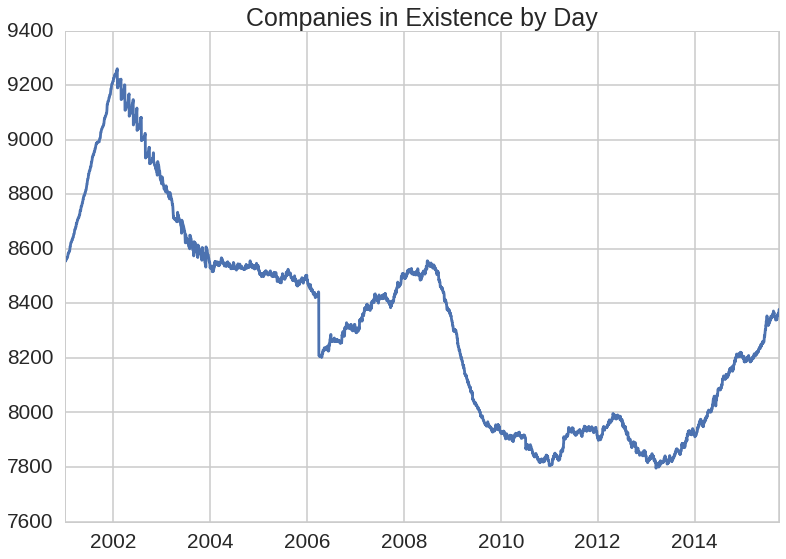

In [4]:
daily_count = lifetimes.sum(axis=1)
daily_count.plot(title="Companies in Existence by Day");

# Splits, Dividends, and Mergers Oh My!

In [5]:
AAPL_prices = pd.read_csv(
    'data_public/AAPL-split.csv', 
    parse_dates=['Date'], 
    index_col='Date',
)

def plot_prices(prices):
    price_plot = prices.plot(title='AAPL Price', grid=False)
    price_plot.set_ylabel("Price", rotation='horizontal', labelpad=50)
    price_plot.vlines(
        ['2014-05-08'], 0, 700, 
        label="$3.05 Dividend", 
        linestyles='dotted',
        colors='black',
    )
    price_plot.vlines(
        ['2014-06-09'], 0, 700, 
        label="7:1 Split", 
        linestyles='--', 
        colors='black',
    )

    price_plot.legend()
    sns.despine()
    return price_plot

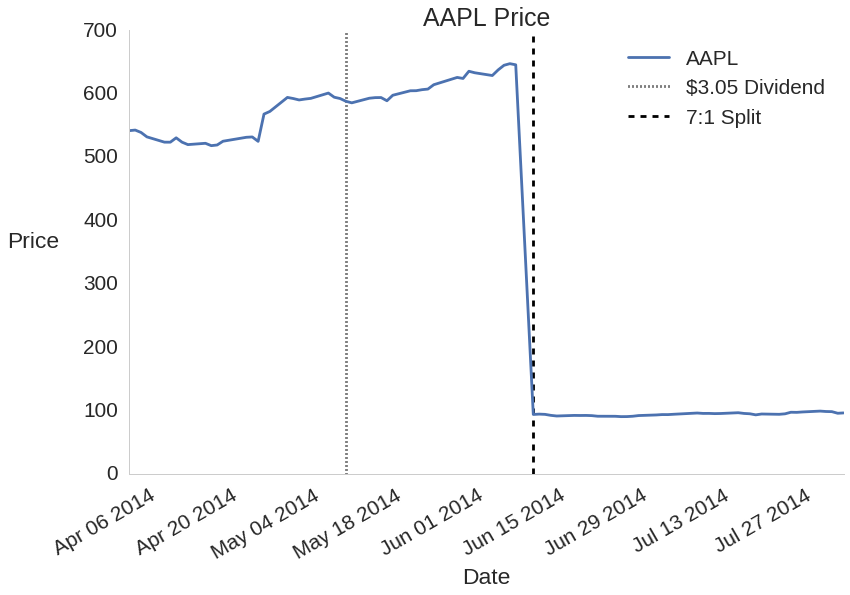

In [6]:
plot_prices(AAPL_prices);

### Prices occurring at different times aren't necessarily comparable.

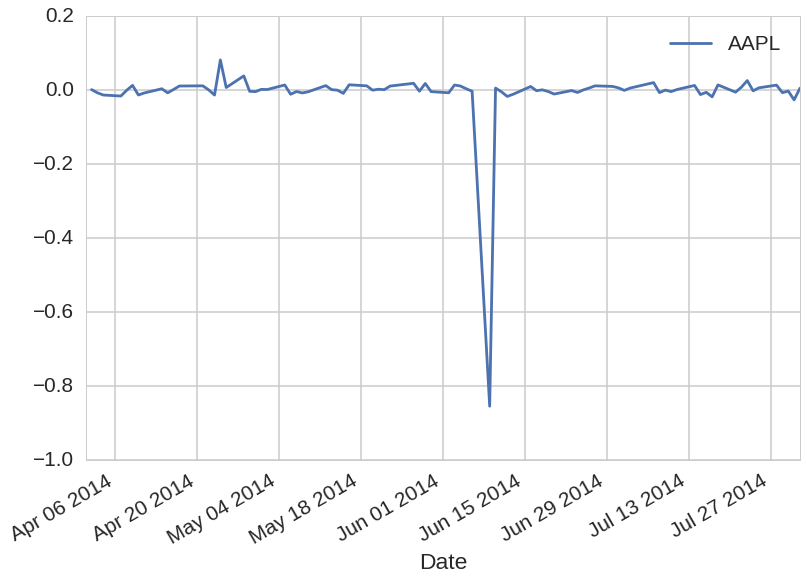

In [7]:
naive_returns = AAPL_prices.pct_change()
naive_returns.plot();

# Restatements

### Hypothetical Scenario:
- On March 5th, Apple announces that it's Q1 revenue was \$15.
- On March 15th, Apple issues an amendment; its Q1 revenue was actually \$15 **billion**.
- User asks for Apple's Q1 revenue.

**Question:** What's the "correct" value to return?

**Answer:** It depends.

- On March 4th, the right answer is "I don't know".
- On Marth 6th, the right answer (as of that date) is \$15.
- On Marth 16th, the right answer is \$15 billion.

# Perspectival Data

Traditional solution to above problems is to use "Adjusted Prices".

- Generally means making prices comparable by normalizing everything to current-day prices.  
- This is what you get from Yahoo/Google Finance APIs.

## Problems with Adjusted Prices:
- Non-reproducible:
  - A backtest run in real time 2014 will see different values for historical prices than a backtest run today.

- Can potentially introduce subtle biases:
  - If algo has access to real price, it can tell a dividend/split is coming.
  - Stocks that have undergone multiple splits will have very low prices in the past.

- Still doesn't help for restatements.
  - Faithfully representing restated values **requires** quoting different values at different sim times.

## When in Doubt, Add Another Dimension

 Naively, we want to say something like this: 

$$D(a, t)$$ 

is the value of dataset $D$ for asset $a$ at time $t$.

This abstraction is broken in the face of splits, dividends, and restatements.

## When in Doubt, Add Another Dimension

What we **can** say is this: 

$$D(a, t, t_{ref})$$

is the value of $D$ for asset $a$ at time $t$ **from the perspective of time $t_{ref}$**.

# Napkin Math:

In [8]:
from bcolz import open
from humanize import naturalsize

all_prices = open('data/equity_daily_bars.bcolz')
min_offset = min(all_prices.attrs['calendar_offset'].itervalues())
max_offset = max(all_prices.attrs['calendar_offset'].itervalues())
calendar = pd.DatetimeIndex(all_prices.attrs['calendar'])[min_offset:max_offset]

nassets = len(lifetimes.columns)
ndates = len(calendar)
nfields = len(('id', 'open', 'high', 'low', 'close', 'volume', 'date'))

print "Number of Assets: %d" % nassets
print "Number of Dates: %d" % ndates
print "Naive Dataset Size: %s" % naturalsize(
    nassets * ndates * nfields * 8
)

Number of Assets: 20353
Number of Dates: 3480
Naive Dataset Size: 4.0 GB


### Data Size on Disk

In [9]:
!du -h -d0 data/equity_daily_bars.bcolz
!du -h -d0 data/adjustments.db

299M	data/equity_daily_bars.bcolz
30M	data/adjustments.db


Tricks used to make dataset smaller:
- Don't store entries on dates for which an asset didn't exist.
  - Instead, store offset into the calendar of the date the asset started/stopped trading.
- Represent data points as 32-bit unsigned ints on disk.
  - Going from 64-bit to 32-bit cuts the data size in half.
  - Switching from floating-point to integer dramatically improves compression ratio.

# Data Structures for Representing Perspectival Data

> **Rule 5:** Data dominates. If you've chosen the right data structures and organized things well, the algorithms will almost always be self-evident. **Data structures**, not algorithms, are central to programming. - Rob Pike

In [10]:
import pandas as pd
from zipline.utils.tradingcalendar import trading_day
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.loaders import USEquityPricingLoader

loader = USEquityPricingLoader.from_files(
    'data/equity_daily_bars.bcolz',
    'data/adjustments.db'
)
dates = pd.date_range(
    '2014-5-20', 
    '2014-06-30', 
    freq=trading_day,
    tz='UTC',
)

In [11]:
# load_adjusted_array() returns a dictionary mapping columns to instances of `AdjustedArray`.
(closes,) = loader.load_adjusted_array(
    columns=[USEquityPricing.close],
    dates=dates,
    assets=pd.Int64Index([24, 5061]),
    mask=None,
).values()
closes

Adjusted Array:

Data:
 array([[ 604.4 ,   39.74],
       [ 604.55,   39.69],
       [ 606.28,   40.35],
       ..., 
       [  90.35,   42.02],
       [  90.92,   41.73],
       [  91.96,   42.24]])

Adjustments:
{13: [Float64Multiply(first_row=0, last_row=13, first_col=0, last_col=0, value=0.142860)]}

In [14]:
dates_iter = iter(dates[4:])
window = closes.traverse(5)
window

_Float64AdjustedArrayWindow
Window Length: 5
Current Buffer:
[[ 604.4     39.74 ]
 [ 604.55    39.69 ]
 [ 606.28    40.35 ]
 [ 607.33    40.105]
 [ 614.14    40.12 ]]
Remaining Adjustments:
{13: [Float64Multiply(first_row=0, last_row=13, first_col=0, last_col=0, value=0.142860)]}

In [15]:
# This cell is run multiple times to show the numbers scrolling up until we hit the split.
data = next(window)
print data
print next(dates_iter)

[[ 604.4     39.74 ]
 [ 604.55    39.69 ]
 [ 606.28    40.35 ]
 [ 607.33    40.105]
 [ 614.14    40.12 ]]
2014-05-27 00:00:00+00:00


# Future Work

### Near Term:
- Classifiers/Normalization schemes
- Non-numeric data types. (Currently we only support `float` and `bool`).
- Datasets that have more than one data point per asset/day.
  - Earnings estimates.
  - Calendars.
  - More exotic data?

### Longer Term:

- Parallel and/or Remote execution engines.
  - Leveraging `dask` is a potentially interesting route.
- Just-in-time compilation of factor compute functions.

# Questions?